### CHECK Import

Alle wichtigen Imports die für dieses Notebook benötigt werden:

In [119]:
print("Versions of the imported modules:")
import pandas as pd
print('pandas:', pd.__version__)
import numpy as np
print('numpy:', np.__version__)
import seaborn as sns
print('seaborn:', sns.__version__)
import re
print('Regex:', re.__version__)
import requests
print('Request:', requests.__version__)


##############################################
from pathlib import Path
# print('pathlib:', Path.__version__)
import matplotlib.pyplot as plt
# print('matplotlib:', plt.__version__)


import os


########################### Modelle

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD



############################### Inits
label_encoder = LabelEncoder()

Versions of the imported modules:
pandas: 2.2.1
numpy: 1.26.4
seaborn: 0.13.2
Regex: 2.2.1
Request: 2.31.0


### CHECK Load Dataset

In [120]:
data_path = Path.cwd()

# Pfad zur CSV-Datei das Später erstellt wird
file_path = data_path/'../csv/pre_processed_data/train_test.csv'
feature_engineering_df = pd.read_csv(file_path)
feature_engineering_df.head(3)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train


In [121]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Dataset      1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### CHECK Feature: Geschlecht ableiten

Es wird versucht über den Namen der Pasagieren (mit Titel/Ansprache z.B Mr.) auf das Geschlecht der Passagiere Rückschlüsse zu ziehen. Grund hierfür ist dass aus rechereche sich ergeben hat das Frauen und Kinder vor den Männern gerettet wurden.

In [122]:
# Funktion, um Namen in ihre Bestandteile zu teilen
def split_name(name):
    parts = re.split(r'[,\. ]+', name)
    surname = parts[0]
    speech = parts[1]
    first_name = " ".join(parts[2:])
    return surname, speech, first_name

# Namen in Bestandteile aufteilen und zu DataFrame hinzufügen
feature_engineering_df[['Surname', 'Speech', 'First_Name']] = feature_engineering_df.apply(lambda x: split_name(x['Name']), axis=1, result_type='expand')

feature_engineering_df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Braund,Mr,Owen Harris
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train,Heikkinen,Miss,Laina
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Train,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Train,Allen,Mr,William Henry


In [123]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Dataset      1309 non-null   object 
 12  Surname      1309 non-null   object 
 13  Speech       1309 non-null   object 
 14  First_Name   1309 non-null   object 
dtypes: float64(3), int64(4), object(8)
memory usage: 153.5+ KB


In [124]:
unique_speech_values = feature_engineering_df["Speech"].unique()
print(unique_speech_values)

['Mr' 'Mrs' 'Miss' 'Master' 'Planke' 'Don' 'Rev' 'Billiard' 'der' 'Walle'
 'Dr' 'Pelsmaeker' 'Mulder' 'y' 'Steen' 'Carlo' 'Mme' 'Impe' 'Ms' 'Major'
 'Gordon' 'Messemaeker' 'Mlle' 'Col' 'Capt' 'Velde' 'the' 'Shawah'
 'Jonkheer' 'Melkebeke' 'Cruyssen' 'Khalil' 'Palmquist' 'Brito']


**Typische Titel**:
  - **'Mr'**: Ein allgemeiner Titel für einen erwachsenen Mann.
  - **'Mrs'**: Ein Titel für eine verheiratete Frau.
  - **'Miss'**: Ein Titel für eine unverheiratete Frau.
  - **'Master'**: Ein traditioneller Titel für einen jungen Mann oder Jungen, oft verwendet für Kinder.
  - **'Don'**: Ein Titel, der in einigen spanischsprachigen Ländern sowie in Italien verwendet wird, oft vor dem Vornamen.
  - **'Rev'** (Reverend): Ein religiöser Titel, verwendet für Mitglieder des Klerus.
  - **'Dr'**: Ein akademischer oder professioneller Titel für Personen, die einen Doktorgrad in einem Fachgebiet haben.
  - **'Mme'** (Madame): Ein französischer Titel für eine verheiratete Frau.
  - **'Ms'**: Ein neutraler Titel für Frauen, unabhängig vom Familienstand.
  - **'Major'**: Ein militärischer Rang.
  - **'Mlle'** (Mademoiselle): Ein französischer Titel für eine unverheiratete Frau.
  - **'Col'** (Colonel): Ein militärischer Rang.
  - **'Capt'** (Captain): Ein militärischer Rang oder ein Titel für den Kapitän eines Schiffs oder Flugzeugs.
  - **'Jonkheer'**: Ein niederländischer Adelstitel, äquivalent zu einem unbeerbten Adligen oder einem "Junker".

**Weniger typische oder kontextabhängige Titel**:
  - **'Planke'**, **'Billiard'**, **'der'**, **'Walle'**, **'Pelsmaeker'**, **'Mulder'**, **'y'**, **'Steen'**, **'Carlo'**, **'Impe'**, **'Gordon'**, **'Messemaeker'**, **'Velde'**, **'the'**, **'Shawah'**, **'Melkebeke'**, **'Cruyssen'** **'Brito'** 

In [125]:
# Liste der spezifischen Werte in 'Speech'
specific_speech_values = [
    'Planke', 'Billiard', 'der', 'Walle', 'Pelsmaeker', 'Mulder', 'y', 'Steen', 
    'Carlo', 'Impe', 'Gordon', 'Messemaeker', 'Velde', 'the', 'Shawah', 
    'Melkebeke', 'Cruyssen', 'Brito'
]

# Filtern des DataFrames, um nur Zeilen mit spezifischen 'Speech'-Werten zu behalten
filtered_df = feature_engineering_df[feature_engineering_df['Speech'].isin(specific_speech_values)]

filtered_df

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name
18,19,0.0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",31.0,1,0,345763,18.0000,NaN,S,Train,Vander,Planke,Mrs Julius (Emelia Maria Vandemoortele)
38,39,0.0,3,"Vander Planke, Miss. Augusta Maria",18.0,2,0,345764,18.0000,NaN,S,Train,Vander,Planke,Miss Augusta Maria
153,154,0.0,3,"van Billiard, Mr. Austin Blyler",40.5,0,2,A/5. 851,14.5000,NaN,S,Train,van,Billiard,Mr Austin Blyler
170,171,0.0,1,"Van der hoef, Mr. Wyckoff",61.0,0,0,111240,33.5000,B19,S,Train,Van,der,hoef Mr Wyckoff
200,201,0.0,3,"Vande Walle, Mr. Nestor Cyriel",28.0,0,0,345770,9.5000,NaN,S,Train,Vande,Walle,Mr Nestor Cyriel
282,283,0.0,3,"de Pelsmaeker, Mr. Alfons",16.0,0,0,345778,9.5000,NaN,S,Train,de,Pelsmaeker,Mr Alfons
286,287,1.0,3,"de Mulder, Mr. Theodore",30.0,0,0,345774,9.5000,NaN,S,Train,de,Mulder,Mr Theodore
307,308,1.0,1,"Penasco y Castellana, Mrs. Victor de Satode (M...",17.0,1,0,PC 17758,108.9000,C65,C,Train,Penasco,y,Castellana Mrs Victor de Satode (Maria Josefa ...
333,334,0.0,3,"Vander Planke, Mr. Leo Edmondus",16.0,2,0,345764,18.0000,NaN,S,Train,Vander,Planke,Mr Leo Edmondus
355,356,0.0,3,"Vanden Steen, Mr. Leo Peter",28.0,0,0,345783,9.5000,NaN,S,Train,Vanden,Steen,Mr Leo Peter


In [126]:
# Entferne die Spalten 'Surname', 'Speech', 'First_Name' aus dem DataFrame
feature_engineering_df = feature_engineering_df.drop(["Surname", "Speech", "First_Name"], axis=1)

# Zeige die ersten Zeilen des angepassten DataFrames
feature_engineering_df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Train
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Train


Erneuter Split diesmal mit den analysierten Anpassungen

In [127]:
# Funktion, um Namen in ihre Bestandteile zu teilen und dabei Sonderfälle zu berücksichtigen
def split_name_advanced(name):
    # Entfernt den Inhalt in Klammern und Anführungszeichen sowie die Klammern und Anführungszeichen selbst
    name_cleaned = re.sub(r'["\(\)].*?["\(\)]', '', name)
    # Zerlegt den Namen anhand von Kommas und Punkten
    parts = re.split(r'[,\.]+ ?', name_cleaned)
    
    # Initialisiert Variablen für die Teile des Namens
    surname = parts[0] if len(parts) > 0 else ""
    speech = parts[1] if len(parts) > 1 else ""
    first_name = " ".join(parts[2:]) if len(parts) > 2 else ""
    
    # Bereinigt den Vornamen von zusätzlichen Leerzeichen
    first_name = re.sub(' +', ' ', first_name).strip()
    
    return surname, speech, first_name

# Angenommen, 'train_data' ist dein DataFrame. Beispiel-Datenstruktur hinzufügen
# Beispiel-Datensatz hier erstellen oder vorhandenen DataFrame 'train_data' verwenden

# Namen in Bestandteile aufteilen und zu DataFrame hinzufügen
feature_engineering_df[['Surname', 'Speech', 'First_Name']] = feature_engineering_df.apply(lambda x: split_name_advanced(x['Name']), axis=1, result_type='expand')


In [128]:
unique_speech_values = feature_engineering_df["Speech"].unique()
print(unique_speech_values)

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


In [129]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Dataset      1309 non-null   object 
 12  Surname      1309 non-null   object 
 13  Speech       1309 non-null   object 
 14  First_Name   1309 non-null   object 
dtypes: float64(3), int64(4), object(8)
memory usage: 153.5+ KB


**Eindeutig geschlechtsspezifische Titel:**
- **'Mr'**: Männlich
- **'Mrs'**: Weiblich, verheiratet
- **'Miss'**: Weiblich, unverheiratet
- **'Master'**: Männlich, typischerweise ein Junge oder sehr junger Mann
- **'Mme'** (Madame): Weiblich, verheiratet
- **'Ms'**: Weiblich, unabhängig vom Familienstand
- **'Mlle'** (Mademoiselle): Weiblich, unverheiratet
- **'Lady'**: Weiblich, verwendet für eine Frau von Adel oder die Ehefrau eines Ritters
- **'Sir'**: Männlich, verwendet für einen Mann, der zum Ritter geschlagen wurde
- **'the Countess'**: Weiblich, die Ehefrau eines Earls oder eine Gräfin in eigenem Recht
- **'Jonkheer'**: Männlich, niederländischer Adelstitel ohne Erbanspruch
- **'Dona'**: Weiblich

**Titel, die potenziell beiden Geschlechtern zugeordnet sein können:**
- **'Don'**: Traditionell männlich, aber in einigen Kulturen auch für Frauen in der Form "Doña" verwendet.
- **'Rev'** (Reverend): Kann sowohl männliche als auch weibliche Geistliche bezeichnen.
- **'Dr'**: Geschlechtsneutral, bezieht sich auf Personen mit einem Doktorgrad in jeglichem Fachbereich.
- **'Major'**, **'Col'** (Colonel), **'Capt'** (Captain): Diese militärischen Ränge sind geschlechtsneutral, da sie sowohl von Männern als auch von Frauen erreicht werden können.

Mit Hilfe der genderize.io API werden die Pasagiere, bei denen das geschlecht nicht über ienen Titel bestimmte werden kann über den Vornamen klassifiziert. 

Hinzufügen des Geschlechtes

In [130]:
def guess_gender_api(name):
    try:
        response = requests.get(f"https://api.genderize.io/?name={name}")
        response.raise_for_status()  # Stellt sicher, dass ein Fehler geworfen wird bei einer fehlschlagenden Anfrage
        data = response.json()
        return 'male' if data['gender'] == 'male' else 'female'
    except Exception as e:
        print(f"API call failed: {e}")
        return None

# Funktion, um das Geschlecht basierend auf dem Titel zu bestimmen oder die API zu verwenden
def determine_sex(row):
    male_titles = ['Mr', 'Master', 'Sir', 'Jonkheer']
    female_titles = ['Mrs', 'Miss', 'Mme', 'Ms', 'Mlle', 'Lady', 'the Countess', 'Dona']
    neutral_titles = ['Don', 'Rev', 'Dr', 'Major', 'Col', 'Capt']

    if row['Speech'] in male_titles:
        return 1
    elif row['Speech'] in female_titles:
        return 0
    elif row['Speech'] in neutral_titles:
        gender = guess_gender_api(row['First_Name'])
        return 1 if gender == 'male' else 0 if gender == 'female' else None
    else:
        return None

### 100 calls pro Tag nur ausführen wenn notwendig
    



# Pfad zur CSV-Datei das Später erstellt wird
file_path = data_path/'../csv/pre_processed_data/train_test_with_sex.csv'


# Überprüfe, ob die Datei existiert
if not os.path.exists(file_path):
    # Füge die neue 'Sex'-Spalte hinzu, indem die Funktion auf jede Zeile angewendet wird
    feature_engineering_df['Sex'] = feature_engineering_df.apply(determine_sex, axis=1)
    # To csv
    feature_engineering_df.to_csv(file_path, index=False)
else:
    print(f"Datei '{file_path}' existiert bereits. Keine API-Aufrufe notwendig.")
    
feature_engineering_df = pd.read_csv(file_path)
feature_engineering_df

Datei 'c:\Users\Ivan\Desktop\datasience_project\notebooks\..\csv\pre_processed_data\train_test_with_sex.csv' existiert bereits. Keine API-Aufrufe notwendig.


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name,Sex
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Braund,Mr,Owen Harris,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train,Cumings,Mrs,John Bradley,0
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train,Heikkinen,Miss,Laina,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Train,Futrelle,Mrs,Jacques Heath,0
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Train,Allen,Mr,William Henry,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,2.0,3,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,NaN,S,Test,Spector,Mr,Woolf,1
1305,1306,2.0,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,C,Test,Oliva y Ocana,Dona,Fermina,0
1306,1307,2.0,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Test,Saether,Mr,Simon Sivertsen,1
1307,1308,2.0,3,"Ware, Mr. Frederick",NaN,0,0,359309,8.0500,NaN,S,Test,Ware,Mr,Frederick,1


In [131]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Dataset      1309 non-null   object 
 12  Surname      1309 non-null   object 
 13  Speech       1309 non-null   object 
 14  First_Name   1290 non-null   object 
 15  Sex          1309 non-null   int64  
dtypes: float64(3), int64(5), object(8)
memory usage: 163.8+ KB


Komisch dass First_Namen verloren gehen von 1290

In [132]:
# Finde alle Zeilen, bei denen 'First_Name' leer ist
rows_with_empty_first_name = feature_engineering_df[feature_engineering_df['First_Name'].isna()]
rows_with_empty_first_name

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name,Sex
15,16,1.0,2,"Hewlett, Mrs. (Mary D Kingcome)",55.0,0,0,248706,16.0000,NaN,S,Train,Hewlett,Mrs,NaN,0
66,67,1.0,2,"Nye, Mrs. (Elizabeth Ramell)",29.0,0,0,C.A. 29395,10.5000,F33,S,Train,Nye,Mrs,NaN,0
166,167,1.0,1,"Chibnall, Mrs. (Edith Martha Bowerman)",NaN,0,1,113505,55.0000,E33,S,Train,Chibnall,Mrs,NaN,0
190,191,1.0,2,"Pinsky, Mrs. (Rosa)",32.0,0,0,234604,13.0000,NaN,S,Train,Pinsky,Mrs,NaN,0
259,260,1.0,2,"Parrish, Mrs. (Lutie Davis)",50.0,0,1,230433,26.0000,NaN,S,Train,Parrish,Mrs,NaN,0
272,273,1.0,2,"Mellinger, Mrs. (Elizabeth Anne Maidment)",41.0,0,1,250644,19.5000,NaN,S,Train,Mellinger,Mrs,NaN,0
327,328,1.0,2,"Ball, Mrs. (Ada E Hall)",36.0,0,0,28551,13.0000,D,S,Train,Ball,Mrs,NaN,0
362,363,0.0,3,"Barbara, Mrs. (Catherine David)",45.0,0,1,2691,14.4542,NaN,C,Train,Barbara,Mrs,NaN,0
367,368,1.0,3,"Moussa, Mrs. (Mantoura Boulos)",NaN,0,0,2626,7.2292,NaN,C,Train,Moussa,Mrs,NaN,0
483,484,1.0,3,"Turkula, Mrs. (Hedwig)",63.0,0,0,4134,9.5875,NaN,S,Train,Turkula,Mrs,NaN,0


Liegt am Regex. Alle Vornamen in Klammern werden daher gelöscht. Da es sich aber nur um Mrs handelt und man das geschlecht eindeutig zuornen kann ist es nicht weiter wichtig. Vornamen sind über das Geschlechterzuweisen nicht relevant.

### CHECK Feature: Title-Mapping

In [133]:
# Ersetzen seltener Titel durch 'Rare'
feature_engineering_df['Title'] = feature_engineering_df['Speech'].replace(
    ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

# Ersetzen von Varianten von 'Miss' und 'Mrs'
feature_engineering_df['Title'] = feature_engineering_df['Speech'].replace('Mlle', 'Miss')
feature_engineering_df['Title'] = feature_engineering_df['Speech'].replace('Ms', 'Miss')
feature_engineering_df['Title'] = feature_engineering_df['Speech'].replace('Mme', 'Mrs')

# Anwendung des Title Mappings
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
feature_engineering_df['Title'] = feature_engineering_df['Title'].map(title_mapping)

# Ersetzen fehlender Werte durch 0
feature_engineering_df['Title'] = feature_engineering_df['Title'].fillna(0)

# Anzeigen der ersten paar Zeilen des DataFrame, um die Änderungen zu überprüfen
feature_engineering_df.head()


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name,Sex,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Braund,Mr,Owen Harris,1,1.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train,Cumings,Mrs,John Bradley,0,3.0
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train,Heikkinen,Miss,Laina,0,2.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Train,Futrelle,Mrs,Jacques Heath,0,3.0
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Train,Allen,Mr,William Henry,1,1.0


### CHECK Feature: Verheiratete Frauen

Durch Titel ist es bei Frauen ableitbar bei Mönnern nicht

In [134]:
feature_engineering_df['Married_Woman'] = 0
feature_engineering_df.loc[feature_engineering_df['Speech'].isin(['Mrs', 'Mme', 'Lady', 'the Countess']), 'Married_Woman'] = 1
feature_engineering_df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name,Sex,Title,Married_Woman
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Train,Braund,Mr,Owen Harris,1,1.0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Train,Cumings,Mrs,John Bradley,0,3.0,1
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train,Heikkinen,Miss,Laina,0,2.0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Train,Futrelle,Mrs,Jacques Heath,0,3.0,1
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Train,Allen,Mr,William Henry,1,1.0,0


### CHECK Feauture: Embarked Auffüllen

In [135]:
embarked_nan = feature_engineering_df[feature_engineering_df["Embarked"].isna()]
embarked_nan

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name,Sex,Title,Married_Woman
61,62,1.0,1,"Icard, Miss. Amelie",38.0,0,0,113572,80.0,B28,NaN,Train,Icard,Miss,Amelie,0,2.0,0
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",62.0,0,0,113572,80.0,B28,NaN,Train,Stone,Mrs,George Nelson,0,3.0,1


Um zu schauen ob Personen alleine reist (Wenn nein hätte man den ABlegehafen eventuell ableiten können)

In [136]:
test = feature_engineering_df[feature_engineering_df["Surname"]=="Icard"]
test

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name,Sex,Title,Married_Woman
61,62,1.0,1,"Icard, Miss. Amelie",38.0,0,0,113572,80.0,B28,NaN,Train,Icard,Miss,Amelie,0,2.0,0


Um zu schauen ob Personen alleine reist (Wenn nein hätte man den ABlegehafen eventuell ableiten können)

In [137]:
test = feature_engineering_df[feature_engineering_df["Surname"]=="Stone"]
test

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dataset,Surname,Speech,First_Name,Sex,Title,Married_Woman
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",62.0,0,0,113572,80.0,B28,NaN,Train,Stone,Mrs,George Nelson,0,3.0,1


Einfach Southempton genommen weil da am meisten eingestiegen sind: Höhste Wahrscheinlichkeit

In [138]:
feature_engineering_df["Embarked"].fillna(value="S", inplace=True)
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       1309 non-null   float64
 2   Pclass         1309 non-null   int64  
 3   Name           1309 non-null   object 
 4   Age            1046 non-null   float64
 5   SibSp          1309 non-null   int64  
 6   Parch          1309 non-null   int64  
 7   Ticket         1309 non-null   object 
 8   Fare           1308 non-null   float64
 9   Cabin          295 non-null    object 
 10  Embarked       1309 non-null   object 
 11  Dataset        1309 non-null   object 
 12  Surname        1309 non-null   object 
 13  Speech         1309 non-null   object 
 14  First_Name     1290 non-null   object 
 15  Sex            1309 non-null   int64  
 16  Title          1309 non-null   float64
 17  Married_Woman  1309 non-null   int64  
dtypes: float

C:\Users\Ivan\AppData\Local\Temp\ipykernel_230728\1881675163.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feature_engineering_df["Embarked"].fillna(value="S", inplace=True)


In [139]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
feature_engineering_df['Embarked_encoded'] = label_encoder.fit_transform(feature_engineering_df['Embarked'])

### CHECK Feature: From Cherbourg

In [140]:
# Funktion, um Punkte basierend auf dem Geschlecht und dem Alter zu berechnen
def calculate_points(row):
    if row['Embarked'] == "C":
        points = 1
    else:
        points = 0
    return points

# Neue Spalte 'Score' mit berechneten Punkten hinzufügen
feature_engineering_df['Is_from_Cherbourg'] = feature_engineering_df.apply(calculate_points, axis=1)


### CHECK Feature: From Queenstownd.

- Pretty much every male that boarded on Queenstown(Q) did not survive.
- There were very few females boarded on Queenstown, however, most of them survive

In [141]:
# Funktion, um Punkte basierend auf dem Geschlecht und dem Alter zu berechnen
def calculate_points(row):
    if row['Embarked'] == "Q" and row['Sex']==1:
        points = 0
    else:
        points = 1
    return points

# Neue Spalte 'Score' mit berechneten Punkten hinzufügen
feature_engineering_df['Is_from_Queenstown'] = feature_engineering_df.apply(calculate_points, axis=1)

### CHECK Feauture: Fare Auffüllen

In [142]:
fare_nan = feature_engineering_df[feature_engineering_df["Fare"].isna()]
fare_nan

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Dataset,Surname,Speech,First_Name,Sex,Title,Married_Woman,Embarked_encoded,Is_from_Cherbourg,Is_from_Queenstown
1043,1044,2.0,3,"Storey, Mr. Thomas",60.5,0,0,3701,NaN,NaN,...,Test,Storey,Mr,Thomas,1,1.0,0,2,0,1


Um zu schauen ob Personen alleine reist (Wenn nein könnte man eventuell den Ticketpreis ableiten)

In [143]:
test= feature_engineering_df[feature_engineering_df["Surname"]=="Storey"]
test

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Dataset,Surname,Speech,First_Name,Sex,Title,Married_Woman,Embarked_encoded,Is_from_Cherbourg,Is_from_Queenstown
1043,1044,2.0,3,"Storey, Mr. Thomas",60.5,0,0,3701,NaN,NaN,...,Test,Storey,Mr,Thomas,1,1.0,0,2,0,1


In [144]:
feature_engineering_df["Fare"].fillna(value=feature_engineering_df["Fare"].mean(), inplace=True)
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         1309 non-null   int64  
 1   Survived            1309 non-null   float64
 2   Pclass              1309 non-null   int64  
 3   Name                1309 non-null   object 
 4   Age                 1046 non-null   float64
 5   SibSp               1309 non-null   int64  
 6   Parch               1309 non-null   int64  
 7   Ticket              1309 non-null   object 
 8   Fare                1309 non-null   float64
 9   Cabin               295 non-null    object 
 10  Embarked            1309 non-null   object 
 11  Dataset             1309 non-null   object 
 12  Surname             1309 non-null   object 
 13  Speech              1309 non-null   object 
 14  First_Name          1290 non-null   object 
 15  Sex                 1309 non-null   int64  
 16  Title 

C:\Users\Ivan\AppData\Local\Temp\ipykernel_230728\375885594.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feature_engineering_df["Fare"].fillna(value=feature_engineering_df["Fare"].mean(), inplace=True)


### CHECK Feature: Fare Klasse

In [145]:
# Funktion, um Punkte basierend auf dem Geschlecht und dem Alter zu berechnen
def calculate_points(row):
    if row['Fare'] >= 75:
        points = 1
    else:
        points = 0
    return points

# Neue Spalte 'Score' mit berechneten Punkten hinzufügen
feature_engineering_df['Cheep_Ticket'] = feature_engineering_df.apply(calculate_points, axis=1)


### CHECK Feature: Cabin Structur

Das aufteilen von Cabin zu Cabin Nummer Cabin_Nr und Board_Deck (Buchstaben aus recherche Quelle) Eventuell hat das einfluss auf die Überlebenschancen Titanik erst vorne gesunken dann zerbrochen...

In [146]:
# Definiere eine Funktion, um Cabin in Boat_Deck und Cabin_Nr aufzuteilen
def split_cabin(cabin):
    if pd.isna(cabin):
        return np.nan, np.nan
    match = re.match(r"([a-zA-Z]+)([0-9]+)?", cabin.replace(" ", ""))
    boat_deck = match.group(1) if match else np.nan
    cabin_nr = match.group(2) if match and match.group(2) else np.nan
    return boat_deck, cabin_nr

# Wende die Funktion auf die Cabin-Spalte an und erstelle zwei neue Spalten
feature_engineering_df[['Boat_Deck', 'Cabin_Nr']] = feature_engineering_df.apply(lambda row: split_cabin(row['Cabin']), axis=1, result_type='expand')


feature_engineering_df['Boat_Deck'].fillna('M', inplace=True)

# Passenger in the T deck is changed to A
idx = feature_engineering_df[feature_engineering_df['Boat_Deck'] == 'T'].index
feature_engineering_df.loc[idx, 'Boat_Deck'] = 'A'


feature_engineering_df['Boat_Deck'] = feature_engineering_df['Boat_Deck'].replace(['A', 'B', 'C'], 'ABC')
feature_engineering_df['Boat_Deck'] = feature_engineering_df['Boat_Deck'].replace(['D', 'E'], 'DE')
feature_engineering_df['Boat_Deck'] = feature_engineering_df['Boat_Deck'].replace(['F', 'G', 'FE'], 'FG')

feature_engineering_df['Boat_Deck'].value_counts()

C:\Users\Ivan\AppData\Local\Temp\ipykernel_230728\4099651746.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feature_engineering_df['Boat_Deck'].fillna('M', inplace=True)


Boat_Deck
M      1014
ABC     182
DE       87
FG       26
Name: count, dtype: int64

In [147]:
test = feature_engineering_df[feature_engineering_df["Boat_Deck"]=="FE"]
test

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,First_Name,Sex,Title,Married_Woman,Embarked_encoded,Is_from_Cherbourg,Is_from_Queenstown,Cheep_Ticket,Boat_Deck,Cabin_Nr


In [148]:
feature_engineering_df['Boat_Deck_encoded'] = label_encoder.fit_transform(feature_engineering_df['Boat_Deck'])
feature_engineering_df.drop(['Cabin','Cabin_Nr'], inplace=True, axis=1)
feature_engineering_df.head(5)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,...,First_Name,Sex,Title,Married_Woman,Embarked_encoded,Is_from_Cherbourg,Is_from_Queenstown,Cheep_Ticket,Boat_Deck,Boat_Deck_encoded
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,...,Owen Harris,1,1.0,0,2,0,1,0,M,3
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,...,John Bradley,0,3.0,1,0,1,1,0,ABC,0
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,S,...,Laina,0,2.0,0,2,0,1,0,M,3
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,S,...,Jacques Heath,0,3.0,1,2,0,1,0,ABC,0
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,S,...,William Henry,1,1.0,0,2,0,1,0,M,3


### CHECK Feature Family-Size

In [149]:
feature_engineering_df['Family_Size'] = (feature_engineering_df['SibSp'] + feature_engineering_df['Parch']+1)
feature_engineering_df.head(1)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Sex,Title,Married_Woman,Embarked_encoded,Is_from_Cherbourg,Is_from_Queenstown,Cheep_Ticket,Boat_Deck,Boat_Deck_encoded,Family_Size
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.25,S,...,1,1.0,0,2,0,1,0,M,3,2


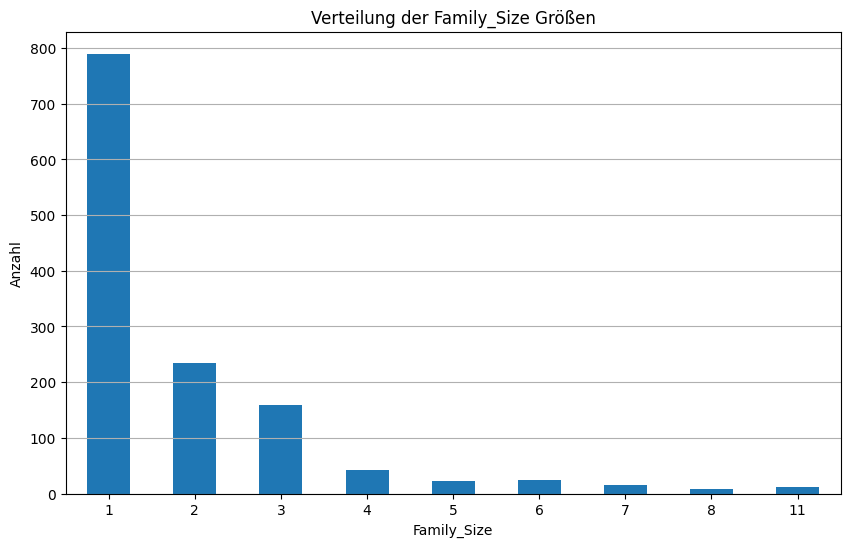

In [150]:
# Erstellung des Barplots
family_size_counts = feature_engineering_df['Family_Size'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
family_size_counts.plot(kind='bar')
plt.title('Verteilung der Family_Size Größen')
plt.xlabel('Family_Size')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Anzeigen des Plots
plt.show()


In [151]:
## bin the family size. 
def family_group(size):
    """
    This funciton groups(loner, small, large) family based on family size
    """
    
    a = ''
    if (size <= 1):
        a = 'loner'
    elif (size <= 4):
        a = 'small'
    else:
        a = 'large'
    return a

# Anwendung der Funktion auf die Family_Size Spalte, um das neue Feature zu erstellen
feature_engineering_df['Family_Size_Label'] = feature_engineering_df['Family_Size'].apply(family_group)

feature_engineering_df['Family_Size_Label_encoded'] = label_encoder.fit_transform(feature_engineering_df['Family_Size_Label'])


### CHECK Feature: Big_Group (Wit Parch) = bad

In [152]:

# Funktion, um Punkte basierend auf dem Geschlecht und dem Alter zu berechnen
def calculate_points(row):
    if row['Parch'] >= 4:
        points = 0
    else:
        points = 1
    return points

feature_engineering_df['big_group_parch'] = feature_engineering_df.apply(calculate_points, axis=1)

### CHECK Feature: Smallgroup wit SibSp = goog

In [153]:
# - While, passenger who traveled in small groups with sibilings/spouses had better changes of survivint than other passengers.
# Funktion, um Punkte basierend auf dem Geschlecht und dem Alter zu berechnen
def calculate_points(row):
    if row['SibSp'] <= 2 and row['Family_Size_Label'] == 'small':
        points = 1
    else:
        points = 0
    return points

feature_engineering_df['small_group_sibsp'] = feature_engineering_df.apply(calculate_points, axis=1)

### CHECK Feature: is Alone

In [154]:
feature_engineering_df['is_alone'] = [1 if i<2 else 0 for i in feature_engineering_df.Family_Size]


### CHECK Feature: is Alone Woman

In [155]:
# # Funktion, um Punkte basierend auf dem Geschlecht und dem Alter zu berechnen
# def calculate_points(row):
#     if row['Family_Size'] <= 2 and row['Family_Size'] <= 2 :
#         points = 1
#     else:
#         points = 0
#     return points

# # Neue Spalte 'Score' mit berechneten Punkten hinzufügen
# feature_engineering_df['Is_Child'] = feature_engineering_df.apply(calculate_points, axis=1)


### CHECK Feature: Fare Split (Für Gruppen)


In [156]:
feature_engineering_df['calculated_fare'] = feature_engineering_df.Fare/feature_engineering_df.Family_Size
# Damit der Preis realistisch ist und Gruppentickets geteilt werden



### Feature: Fare Group

In [157]:
from sklearn.preprocessing import LabelEncoder

# Definition der fare_group Funktion
def fare_group(fare):
    """
    This function creates a fare group based on the fare provided.
    """
    if fare <= 4:
        return 'Very_low'
    elif fare <= 10:
        return 'low'
    elif fare <= 20:
        return 'mid'
    elif fare <= 45:
        return 'high'
    else:
        return 'very_high'

# Anwendung der fare_group Funktion auf den DataFrame
feature_engineering_df['fare_group'] = feature_engineering_df['calculated_fare'].apply(fare_group)

# Kodierung der 'Speech' Spalte mit einem Label Encoder
label_encoder = LabelEncoder()
feature_engineering_df['fare_group_encoded'] = label_encoder.fit_transform(feature_engineering_df['fare_group'])


### CHECK Feature: Ticketnummer

In [158]:
# Funktion zum Aufteilen der Ticket-Spalte
def split_ticket_column(df):
    # Extrahiere numerische Werte
    df['Ticketnummer'] = df['Ticket'].apply(lambda x: ''.join(re.findall(r'\d+', x)))
    # Extrahiere Buchstaben (nicht-numerische Zeichen) und entferne Leerzeichen
    df['Ticketkey'] = df['Ticket'].apply(lambda x: ''.join(re.findall(r'[^\d\s]+', x)))
    
    # Konvertiere Ticketnummer zu Integer
    # Hinweis: Einige Werte könnten leer sein, setze diese auf einen Standardwert (z.B. 0) vor der Konversion
    df['Ticketnummer'] = df['Ticketnummer'].apply(lambda x: int(x) if x else 0)
    
    return df

# Anwenden der Funktion
feature_engineering_df = split_ticket_column(feature_engineering_df)

feature_engineering_df.head()


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Family_Size_Label,Family_Size_Label_encoded,big_group_parch,small_group_sibsp,is_alone,calculated_fare,fare_group,fare_group_encoded,Ticketnummer,Ticketkey
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,...,small,2,1,1,0,3.62500,Very_low,0,521171,A/
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,...,small,2,1,1,0,35.64165,high,1,17599,PC
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,S,...,loner,1,1,0,1,7.92500,low,2,23101282,STON/O.
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,S,...,small,2,1,1,0,26.55000,high,1,113803,
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,S,...,loner,1,1,0,1,8.05000,low,2,373450,


### CHECK Feature: Surename-ID 

In [159]:
feature_engineering_df['SurnameID'], _ = pd.factorize(feature_engineering_df['Surname'])
# Count unique SurnameIDs
unique_surname_ids_count = feature_engineering_df['SurnameID'].nunique()
unique_surname_ids_count

875

### CHECK Feature: Group_Survival (Surename-Groupe) 

In [160]:
# Zuerst kennzeichnen wir alle SurnameID's, die nur einmal vorkommen, mit einem speziellen Wert
surname_counts = feature_engineering_df['SurnameID'].value_counts()
single_surname_id = -1  # Ein spezieller Wert für Nachnamen, die nur einmal vorkommen
feature_engineering_df['GroupedSurnameID'] = feature_engineering_df['SurnameID'].apply(lambda x: single_surname_id if surname_counts[x] == 1 else x)

# Passagiere, deren `Survived`-Wert 2 ist, ignorieren
survived_filtered = feature_engineering_df[feature_engineering_df['Survived'] != 2].copy()

# Durchschnittliche Überlebensrate für jede Gruppe der SurnameID berechnen
average_survival_rate = survived_filtered.groupby('GroupedSurnameID')['Survived'].mean().reset_index(name='GroupSurvival')

# Durchschnittliche Überlebensrate dem ursprünglichen DataFrame hinzufügen
feature_engineering_df = feature_engineering_df.merge(average_survival_rate, on='GroupedSurnameID', how='left')

# Wenn du möchtest, dass 'GroupSurvival' nur für die Zeilen mit 'Survived' != 2 berechnet wird,
# kannst du stattdessen 'survived_filtered' für den Merge verwenden und dann zurück zu 'feature_engineering_df' wechseln.


In [161]:
feature_engineering_df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,...,small_group_sibsp,is_alone,calculated_fare,fare_group,fare_group_encoded,Ticketnummer,Ticketkey,SurnameID,GroupedSurnameID,GroupSurvival
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,...,1,0,3.62500,Very_low,0,521171,A/,0,0,0.000000
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,...,1,0,35.64165,high,1,17599,PC,1,1,1.000000
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,S,...,0,1,7.92500,low,2,23101282,STON/O.,2,-1,0.333333
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,S,...,1,0,26.55000,high,1,113803,,3,3,0.500000
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,S,...,0,1,8.05000,low,2,373450,,4,4,0.500000


### CHECK Feature: Is Old

In [162]:
# Funktion, um Punkte basierend auf dem Geschlecht und dem Alter zu berechnen
def calculate_points(row):
    if row['Age'] >= 60:
        points = 1
    else:
        points = 0
    return points

# Neue Spalte 'Score' mit berechneten Punkten hinzufügen
feature_engineering_df['Is_Old'] = feature_engineering_df.apply(calculate_points, axis=1)

### CHECK Feature: Is Mother

In [163]:
# Funktion, um Punkte basierend auf dem Geschlecht und dem Alter zu berechnen
def calculate_points(row):
    if row['Sex'] == 0 and row['Parch'] >=2:
        points = 1
    else:
        points = 0
    return points

# Neue Spalte 'Score' mit berechneten Punkten hinzufügen
feature_engineering_df['Is_Mother'] = feature_engineering_df.apply(calculate_points, axis=1)

### CHECK Feature Is Father

In [164]:
# Funktion, um Punkte basierend auf dem Geschlecht und dem Alter zu berechnen
def calculate_points(row):
    if row['Sex'] == 1 and row['Parch'] >=2:
        points = 1
    else:
        points = 0
    return points

# Neue Spalte 'Score' mit berechneten Punkten hinzufügen
feature_engineering_df['Is_Father'] = feature_engineering_df.apply(calculate_points, axis=1)

### CHECK Feauture: Alter Auffüllen

Letzte Änderung:
- Embarked raus genommen (weil die Regression eventuell so falsch beeinflusst wird)

In [165]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                1309 non-null   int64  
 1   Survived                   1309 non-null   float64
 2   Pclass                     1309 non-null   int64  
 3   Name                       1309 non-null   object 
 4   Age                        1046 non-null   float64
 5   SibSp                      1309 non-null   int64  
 6   Parch                      1309 non-null   int64  
 7   Ticket                     1309 non-null   object 
 8   Fare                       1309 non-null   float64
 9   Embarked                   1309 non-null   object 
 10  Dataset                    1309 non-null   object 
 11  Surname                    1309 non-null   object 
 12  Speech                     1309 non-null   object 
 13  First_Name                 1290 non-null   objec

In [166]:
feature_engineering_df['Surname_encoded'] = label_encoder.fit_transform(feature_engineering_df['Surname'])
# feature_engineering_df['Embarked_encoded'] = label_encoder.fit_transform(feature_engineering_df['Embarked'])
feature_engineering_df['Speech_encoded'] = label_encoder.fit_transform(feature_engineering_df['Speech'])



# Wähle Features, die für die Vorhersage des Alters verwendet werden sollen
# Dies ist ein Beispiel. Du solltest die Features basierend auf deinem Wissen über die Daten auswählen


features = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Sex', 'Speech_encoded']


# DataFrame, in dem Age bekannt ist
df_known_age = feature_engineering_df.dropna(subset=['Age'])

# DataFrame, in dem Age fehlt
df_unknown_age = feature_engineering_df[feature_engineering_df['Age'].isnull()]


# Initialisiere das Random Forest Modell
model_rf = RandomForestRegressor(n_estimators=1500, random_state=42) # Du kannst mit diesen Parametern experimentieren



# Wähle die Features und das Target für die Kreuzvalidierung aus
X = df_known_age[features]
y = df_known_age['Age']

# Führe die Kreuzvalidierung durch
# cv=5 definiert die Anzahl der Folds
# scoring='neg_mean_squared_error' bedeutet, dass der negative mittlere quadratische Fehler als Metrik verwendet wird
scores = cross_val_score(model_rf, X, y, cv=5, scoring='neg_mean_squared_error')

# Konvertiere die Scores in positive Werte
mse_scores = -scores

# Berechne die durchschnittliche Leistung
print(f"Durchschnittlicher MSE: {mse_scores.mean()} (je kleiner, desto besser)")
print(f"Standardabweichung der MSE: {mse_scores.std()} (je kleiner, desto besser)")


# Trainiere das Modell mit den bekannten Alterswerten
model_rf.fit(df_known_age[features], df_known_age['Age'])

# Mache Vorhersagen für die fehlenden Alterswerte
predicted_ages_rf = model_rf.predict(df_unknown_age[features])

# Füge die vorhergesagten Werte in den DataFrame ein
feature_engineering_df.loc[feature_engineering_df['Age'].isnull(), 'Age'] = predicted_ages_rf

Durchschnittlicher MSE: 131.40239460597363 (je kleiner, desto besser)
Standardabweichung der MSE: 16.575858025562493 (je kleiner, desto besser)


### CHECK Feature: Is Child

In [167]:
# Funktion, um Punkte basierend auf dem Geschlecht und dem Alter zu berechnen
def calculate_points(row):
    if row['Age'] <= 8:
        points = 1
    else:
        points = 0
    return points

# Neue Spalte 'Score' mit berechneten Punkten hinzufügen
feature_engineering_df['Is_Child'] = feature_engineering_df.apply(calculate_points, axis=1)


### CHECK Feature: Survived

In [168]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                1309 non-null   int64  
 1   Survived                   1309 non-null   float64
 2   Pclass                     1309 non-null   int64  
 3   Name                       1309 non-null   object 
 4   Age                        1309 non-null   float64
 5   SibSp                      1309 non-null   int64  
 6   Parch                      1309 non-null   int64  
 7   Ticket                     1309 non-null   object 
 8   Fare                       1309 non-null   float64
 9   Embarked                   1309 non-null   object 
 10  Dataset                    1309 non-null   object 
 11  Surname                    1309 non-null   object 
 12  Speech                     1309 non-null   object 
 13  First_Name                 1290 non-null   objec

In [169]:
# # Funktion, um Punkte basierend auf dem Geschlecht und dem Alter zu berechnen
# def calculate_points(row):
#     if row['Is_Child'] == 1 and  :
#         points = 1
#     else:
#         points = 0
#     return points

# # Neue Spalte 'Score' mit berechneten Punkten hinzufügen
# feature_engineering_df['Is_Child'] = feature_engineering_df.apply(calculate_points, axis=1)

### CHECK Feature: Alters-Gruppen

In [170]:
## create bins for age
def age_group_fun(age):
    """
    This function creates a bin for age
    """
    a = ''
    if age <= 1:
        a = 'infant'
    elif age <= 4: 
        a = 'toddler'
    elif age <= 13:
        a = 'child'
    elif age <= 18:
        a = 'teenager'
    elif age <= 35:
        a = 'Young_Adult'
    elif age <= 45:
        a = 'adult'
    elif age <= 55:
        a = 'middle_aged'
    elif age <= 65:
        a = 'senior_citizen'
    else:
        a = 'old'
    return a
        
## Applying "age_group_fun" function to the "Age" column.
feature_engineering_df['age_group'] = feature_engineering_df['Age'].map(age_group_fun)

feature_engineering_df['age_group_encoded'] = label_encoder.fit_transform(feature_engineering_df['age_group'])


# ## Creating dummies for "age_group" feature. 
# train = pd.get_dummies(train,columns=['age_group'], drop_first=True)
# test = pd.get_dummies(test,columns=['age_group'], drop_first=True);

### CHECK Feature: Passagier Clustering (Passagier Relationship)

Letzte Änderung:
- Ticket-Hotencoded damit es verwendbar ist


Alle mit Passagiere mit clustering groupiert und alle aus gleichem Cluster bekommen gleiche  ID

In [171]:
def apply_weighting(df):
    # Berechnung der gewichteten und aggregierten Features
    df['Pclass_weighted'] = df['Pclass'] * 4
    df['Family_Size_weighted'] = df['Family_Size'] * 5
    df['Surname_encoded_weigthed'] = df['Surname_encoded'] * 10
    return df


# Vorverarbeitungspipeline definieren
numerical_features = ['Fare', 'Pclass_weighted', 'Family_Size_weighted', 'Surname_encoded_weigthed', 'Age','Speech_encoded', 'Sex', 'Embarked_encoded', 'Ticketnummer']  # Füge 'Surname_encoded' zu den numerischen Features hinzu
# categorical_features = ['Ticket']

# Imputer für numerische und kategorische Daten
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='constant', fill_value='missing')

# Erstellen der Vorverarbeitungspipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', numerical_imputer), ('scaler', StandardScaler())]), numerical_features),
     #   ('cat', Pipeline([('imputer', categorical_imputer), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
    ]
)

# Gewichtete Features hinzufügen und NaN-Werte behandeln
weighted_df = apply_weighting(feature_engineering_df)
X_preprocessed = preprocessor.fit_transform(weighted_df)


# Anzahl der Komponenten anpassen
n_components = min(X_preprocessed.shape[1], 50)  # Beispiel: Maximal 50 oder weniger, basierend auf der Anzahl der Features
svd = TruncatedSVD(n_components=n_components)
X_svd = svd.fit_transform(X_preprocessed)


# Anwendung von hierarchischem Clustering nach der Dimensionalitätsreduktion
# Wir verwenden 'ward' als Linkage-Kriterium, das darauf abzielt, die Varianz in jedem Cluster zu minimieren.
# 'n_clusters' ist optional und kann angepasst werden, um die Anzahl der gewünschten Cluster festzulegen.
agglomerative = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5, linkage='ward')
clusters_agg = agglomerative.fit_predict(X_svd)

# Aktualisierung der Cluster-Labels
weighted_df['Family_Cluster_Agg'] = clusters_agg
family_id_map_agg = {cluster_id: idx+1 for idx, cluster_id in enumerate(set(clusters_agg)) if cluster_id != -1}
weighted_df['ClusterID'] = weighted_df['Family_Cluster_Agg'].map(family_id_map_agg).fillna(0)
weighted_df.drop(["Family_Cluster_Agg"], axis=1, inplace=True)
feature_engineering_df = weighted_df
feature_engineering_df.head(2)


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Is_Father,Surname_encoded,Speech_encoded,Is_Child,age_group,age_group_encoded,Pclass_weighted,Family_Size_weighted,Surname_encoded_weigthed,ClusterID
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,...,0,100,12,0,Young_Adult,0,12,10,1000,93
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,...,0,182,13,0,adult,1,4,10,1820,711


Um Fälle zu identifizieren, bei denen Passagiere potenziell familiär verbunden sind, und diese Information in einer neuen Spalte `Fam_Related` im Datensatz festzuhalten, können wir ein detailliertes Regelwerk aufstellen. Dieses Regelwerk basiert auf einer Reihe von Kriterien, die gemeinsame Merkmale zwischen den Passagieren hervorheben. Hier die verfeinerten Kriterien:

1. **Gleicher Nachname (`Surname`)**: Dies ist ein starker Indikator für eine familiäre Verbindung.
2. **Identischer Abfahrtshafen (`Embarked`)**: Passagiere, die am gleichen Ort einsteigen, könnten zusammen reisen.
3. **Ticketnummernähnlichkeit (`Ticket`)**: Ähnliche oder sequenzielle Ticketnummern deuten darauf hin, dass die Tickets zusammen gekauft wurden.
4. **Gleiche Passagierklasse (`Pclass`)**: Eine Übereinstimmung in der Klassenwahl kann weitere Hinweise auf eine gemeinsame Reiseplanung geben.
5. **Ticketpreisähnlichkeit (`Fare`)**: Ein nahezu identischer Ticketpreis, innerhalb einer kleinen Toleranz (z.B. ±5 Einheiten), kann auf eine Gruppenbuchung hindeuten.
6. **Altersähnlichkeit (`Age`)**: Ein Altersunterschied innerhalb einer akzeptablen Spanne (z.B. ±10 Jahre) könnte auf Geschwister oder Cousinen und Cousins hindeuten.
7. **Fehlende direkte Verwandtschaftsbeziehungen (`SibSp`, `Parch`)**: Die Abwesenheit direkter familiärer Bindungen (beide Spalten gleich 0) schließt enge Verwandtschaft aus, lässt aber Raum für erweiterte familiäre Beziehungen.

Das Regelwerk ermöglicht es, potenzielle familiäre Verbindungen zu ermitteln, auch wenn keine direkten Verwandtschaftsverhältnisse (wie Geschwister oder Eltern-Kind-Beziehungen) vorliegen. Es hilft, Passagiere zu identifizieren, die aufgrund ähnlicher Umstände und Merkmale wahrscheinlich in einer Beziehung zueinander stehen, wie beispielsweise Cousins und Cousinen. Durch die Anwendung dieser Kriterien auf den Datensatz können interessante Muster und Beziehungen zwischen den Passagieren aufgedeckt werden, die für weitere Analysen und Einsichten von Bedeutung sein könnten.

In [172]:
# from itertools import count

# def ticket_number_difference(ticket1, ticket2):
#     # Entferne alle Nicht-Ziffern und konvertiere zu int, falls möglich
#     try:
#         num1, num2 = int(''.join(filter(str.isdigit, ticket1))), int(''.join(filter(str.isdigit, ticket2)))
#     except ValueError:
#         # Wenn die Konvertierung fehlschlägt, setze einen hohen Wert, um anzudeuten, dass die Tickets nicht ähnlich sind
#         return 9999
#     # Berechne die Differenz
#     return abs(num1 - num2)

# def check_familial_relationship(row, df):
#     fare_difference_threshold = 1000
#     relations = 0
#     for _, potential_relative in df[(df['Surname'] == row['Surname']) & (df['PassengerId'] != row['PassengerId'])].iterrows():
#         if (row['Embarked'] == potential_relative['Embarked']) and \
#            (row['Pclass'] == potential_relative['Pclass']) and \
#            (abs(row['Fare'] - potential_relative['Fare']) <= fare_difference_threshold) and \
#            (ticket_number_difference(row['Ticket'], potential_relative['Ticket']) <= 300):
#             relations += 1
#     return relations

# # Anwenden der Funktion auf jede Zeile und Erstellen der neuen Spalte 'Other_Fam_Members'
# feature_engineering_df['Other_Fam_Members'] = feature_engineering_df.apply(lambda row: check_familial_relationship(row, feature_engineering_df), axis=1)

# # Generierung einer eindeutigen Familien-ID für jede potenzielle Familie
# family_id_counter = count(start=1)
# family_id_map = {}
# for index, row in feature_engineering_df.iterrows():
#     key = (row['Surname'], row['Ticket'][:min(3, len(row['Ticket']))])  # Verwende die ersten 3 Zeichen des Tickets für die Schlüsselbildung
#     if key not in family_id_map:
#         family_id_map[key] = next(family_id_counter)
#     feature_engineering_df.at[index, 'Family_ID'] = family_id_map[key]




- Other_Fam_Members: Sind alle Familienmitglieder die anhand der Kriterien berehcnet wurdern. (ohne dass man sich mitzählt) (ist ein Guess)
- Blood_Fam_Members: Sind die Familien-Mitglieder die durch das summieren von SibSp und Parch entsteht (ohne dass man sich mitzählt) (harte Zahlen)
- Total_Blood_Fam_Members: Sind die Familien-Mitglieder die durch das summieren von SibSp und Parch entsteht (+ sich selber +1) (harte Zahlen)
- Total_Fam: Ist die gesamte Familie mit sich selber (+1) 
    - Wenn Other_Fam_Members == Blood_Fam_Members nicht unterscheiden, ist davon auszugehen, dass nur die direkt in verbindung stehende Familie an Board ist (Mutter Vater Kind  kein Cousin) und Total_Fam = Total_Blood_Fam_Members
    - Wenn Other_Fam_Members > als Blood_Fam_Members dann ist davon auszugehen, dass neben der Blut-Familie noch weiter Familienmitgleider wie Cousinen und Cousin an Board sind und die Total_Fam = Other_Fam_Members + 1
    - Wenn Blood_Fam_Members > als Other_Fam_Members dann ist davon auszugehen, dass das Regelwerk zum berechnen von Other_Fam_Members nicht funktioniert hat bzw. dass es einen Ausreiser gab (z.B. der Vater hat sein Ticket in einer anderen Stadt gekauft und ist woanders der Titanik zugestoßen) dann ist der Score Other_Fam_Members nciht vertrauenswürdig und Total_Fam = Total_Blood_Fam_Members. Zusätlich müssen diese Sonderfälle in einer weitern Spalte markiert werden.

Um deine Anforderungen umzusetzen, werde ich die gewünschten Berechnungen durchführen und entsprechende Spalten in `feature_engineering_df` hinzufügen. Die Anforderungen sind:

1. `Other_Fam_Members`: Die Anzahl der Familienmitglieder, die anhand der Kriterien berechnet wurden, ohne den Passagier selbst mitzuzählen. Dies basiert auf einer Schätzung und wird als bereits berechnet angenommen.
2. `Blood_Fam_Members`: Die Anzahl der Familienmitglieder, die durch das Summieren von `SibSp` und `Parch` entsteht, ohne den Passagier selbst mitzuzählen.
3. `Total_Blood_Fam_Members`: Die Anzahl der Familienmitglieder, die durch das Summieren von `SibSp` und `Parch` entsteht, inklusive des Passagiers selbst (+1).
4. `Total_Fam`: Die Gesamtanzahl der Familie inklusive des Passagiers selbst (+1), basierend auf den gegebenen Regeln.

Dieser Code führt die Berechnungen basierend auf den bereitgestellten Regeln durch und fügt die resultierenden Werte als neue Spalten dem DataFrame hinzu. Die `Special_Case` Spalte markiert Fälle, in denen die Anzahl der direkten Blutsverwandten größer ist als die Anzahl der anhand der Kriterien geschätzten erweiterten Familienmitglieder, was darauf hindeutet, dass das Regelwerk möglicherweise nicht korrekt angewendet wurde oder es Ausnahmefälle gibt.

### CHECK Feauture: Group-Survival

Idee von meiner Family Gruppe nehem ich jetzt den Durchschnitt der überelebeten und füge diese Zahl allen Personen der Gruppe hinzu 

In [173]:
# Passagiere, deren `Survived`-Wert 2 ist, ignorieren und durchschnittliche Überlebensrate berechnen
survived_filtered = feature_engineering_df[feature_engineering_df['Survived'] != 2].copy()

# Durchschnittliche Überlebensrate für jede Nachnamensgruppe berechnen
average_survival_rate = survived_filtered.groupby('Surname')['Survived'].mean().reset_index(name='AverageSurvivalRate')

# Durchschnittliche Überlebensrate dem ursprünglichen DataFrame hinzufügen
feature_engineering_df = feature_engineering_df.merge(average_survival_rate, on='Surname', how='left')

# Ersetze NaN in `AverageSurvivalRate` basierend auf den Bedingungen
def update_average_survival(row):
    if pd.isna(row['AverageSurvivalRate']):
        return row['Survived']
    return row['AverageSurvivalRate']

# Aktualisiere `AverageSurvivalRate` für alle Zeilen
feature_engineering_df['AverageSurvivalRate'] = feature_engineering_df.apply(update_average_survival, axis=1)

# Setze `AverageSurvivalRate` auf -1 für alle Personen, deren `Survived` 2 ist
feature_engineering_df.loc[feature_engineering_df['Survived'] == 2.0, 'AverageSurvivalRate'] = 0

### Dataframes bauen

In [175]:


features = ['PassengerId', 'Dataset', 'Survived', 'Sex', 'Pclass', 'Is_from_Cherbourg', 'Is_Child']

# Features zum Überlegen
# Is Father from Young Child
# Is Mother from Young Child


'''
Umständliches Regelwerk

Wenn Man dann 0 -> wenn man aus p3 -> 0 wenn man aus p1 dann 1 -> wenn aus dem einen Hafen dann  1 ->  Wenn kind dann 1 (jünger 15) -> wenn aus dem anderen hafen dann 0 etc. -> Wenn vater etc.
Wenn Frau dann 1 -> Wenn frau aus dem Crazy hafen dann 0 -> w
'''

'''
Features die Score Verschlechtern: (Alle Features in Kombination mit Sex)
- Is_Child
- Fare
- SurnameID (Mit Clustering)
- Age
- 'AverageSurvivalRate' (EXTREM unter 50 Prozent aber Accurancy auf Testdaten 96% -> Muss man besser machen)
- 'Ticketnummer'
- 'Surname_encoded'
-'Speech_encoded'
- 'Title'
- 'calculated_fare'
- 'SurnameID'
- GroupSurvival (Katastrophal für den Score Sehr gut für Accurancy)
- GroupedSurnameID
- 'small_group_sibsp'


'''

'''
Features die Score nicht beeinflussen: (Alle Features in Kombination mit Sex)
- Pclass
- Embarked_encoded
- 'Married_Woman'
- 'Is_from_Cherbourg'
- 'Cheep_Ticket'
- fare_group_encoded (In der Gruppe aber negativer Einfluss)
- 'is_alone' (In der Gruppe aber negativer Einfluss)
- 'Is_Old' (In der Gruppe aber negativer Einfluss)
-  'Is_from_Queenstown' (in der Guppe beinflusst dieses Feature den Score nicht)

'''

'''
Features die Score Verbessern: (Alle Features in Kombination mit Sex)
- 'Parch' (Ohne SibSp verbesserung um 0.2 mit SibSp keine erhöhung)
- 'SibSp' (Um 0.5)
- 'Family_Size' (gleichgut wie SibSp keinen Unterschied)
- 'Family_Size_Label_encoded'
- 'Is_Mother' (alleine kaum aber in der Gruppe)
- 'Is_Father' (alleine kaum aber in der Gruppe)


'''

'''
Features Kombinationen die Score Verbessern: (Alle Features in Kombination mit Sex)
-  79.9 = 'PassengerId', 'Dataset', 'Survived', 'Sex', 'Pclass', 'Is_from_Cherbourg', 'Is_Child' (Is Child Feature von 4 Jahre auf 8 Angepasst)
-  79.1 = 'PassengerId', 'Dataset', 'Survived', 'Sex', 'Pclass', 'Is_from_Cherbourg', 'Is_Child'
-  78.9 = 'Family_Size_Label_encoded' + 'Pclass' + 'Is_from_Cherbourg' (Hat minimal positiven einfluss 0.07) +'Is_Child' (keinen Unterschied) + 'Cheep_Ticket' (keinen Unterschied) + Is_Father' (um 0.7 auf 78.2)
-  78.2 = 'Family_Size_Label_encoded' + 'Pclass' + 'Is_from_Cherbourg' (Hat minimal positiven einfluss 0.07) +'Is_Child' (keinen Unterschied) + 'Cheep_Ticket' (keinen Unterschied)+ Is_Mother' (um 0.7 auf 78.2)

'''




# features = ['PassengerId','Survived','Pclass', 'Age', 'SibSp', 'Parch', 'Ticketnummer', 'Fare', 'Dataset', 'Sex', 'SurnameID', 'Surname_encoded', 'Embarked_encoded', 'Speech_encoded', 'Family_Size', 'Score','Married_Woman']

feature_engineering_df = feature_engineering_df[features]


# # rom sklearn.preprocessing import StandardScaler
# st_scale = StandardScaler()

# # transforming "train_x"
# feature_engineering_df = st_scale.fit_transform(feature_engineering_df)




# Aufteilen in Trainings- und Testdaten
train = feature_engineering_df[feature_engineering_df['Dataset']=="Train"].drop(['Dataset'], axis=1)
test = feature_engineering_df[feature_engineering_df['Dataset']=="Test"].drop(['Dataset'], axis=1)

# Speichern als CSV
train.to_csv( data_path/'../csv/feature_data/train_engineered.csv', index=False)
test.to_csv(data_path/'../csv/feature_data/test_engineered.csv', index=False)

In [176]:
test.head()

,PassengerId,Survived,Sex,Pclass,Is_from_Cherbourg,Is_Child,FareBin_Code,AgeBin_Code
891,892,2.0,1,3,0,0,0,2
892,893,2.0,0,3,0,0,0,3
893,894,2.0,1,2,0,0,1,3
894,895,2.0,1,3,0,0,1,1
895,896,2.0,0,3,0,0,2,0


In [177]:
train.head()

,PassengerId,Survived,Sex,Pclass,Is_from_Cherbourg,Is_Child,FareBin_Code,AgeBin_Code
0,1,0.0,1,3,0,0,0,0
1,2,1.0,0,1,1,0,4,3
2,3,1.0,0,3,0,0,1,1
3,4,1.0,0,1,0,0,4,2
4,5,0.0,1,3,0,0,1,2


Ideen: 
- Fare Normalisierren
- Verschiedene Modelle ausprobieren (https://www.kaggle.com/code/niteshyadav3103/titanic-eda-prediction-top-8)
- Fare kleiner als 100 hieß dass viele gestorben sind

https://www.kaggle.com/code/masumrumi/a-statistical-analysis-ml-workflow-of-titanic/notebook
- Pretty much every male that boarded on Queenstown(Q) did not survive.
- There were very few females boarded on Queenstown, however, most of them survived.
- Passenger who traveled in big groups with parents/children had less survival rate than other passengers.
- While, passenger who traveled in small groups with sibilings/spouses had better changes of survivint than other passengers.

To-Do missing values aufschreiben